# Import Data and convert appropriate column to float

In [1]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ThuanSession').getOrCreate()

In [2]:
df= spark.read.option("header",True).csv("insurance.csv")

In [3]:
print("Row: ", df.count())
print("Cols:", len(df.dtypes))

Row:  1338
Cols: 7


In [4]:
df.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|    33|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [5]:
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- children: string (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: string (nullable = true)



In [6]:
df=df.withColumn('age',df['age'].cast("float").alias('age'))
df=df.withColumn('bmi',df['bmi'].cast("float").alias('bmi'))
df=df.withColumn('children',df['children'].cast("float").alias('children'))
df=df.withColumn('charges',df['charges'].cast("float").alias('charges'))

In [7]:
df.printSchema()

root
 |-- age: float (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: float (nullable = true)
 |-- children: float (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: float (nullable = true)



# Data summary of numeric column

In [8]:
df.describe(['age','bmi','children','charges']).show()

+-------+------------------+-----------------+-----------------+------------------+
|summary|               age|              bmi|         children|           charges|
+-------+------------------+-----------------+-----------------+------------------+
|  count|              1338|             1338|             1338|              1338|
|   mean| 39.20702541106129|30.66339685599722|  1.0949177877429|13270.422259640089|
| stddev|14.049960379216147|6.098186944544972|1.205492739781914|12110.011235594102|
|    min|              18.0|            15.96|              0.0|         1121.8739|
|    max|              64.0|            53.13|              5.0|          63770.43|
+-------+------------------+-----------------+-----------------+------------------+



In [9]:
from pyspark.sql.functions import concat_ws,col
dfPlot = df.groupBy(["sex","smoker"]).count()
dfPlot=dfPlot.select(concat_ws(' ',df.sex,df.smoker).alias("Sex_Smoker"),"count")
dfPlot.show()

+----------+-----+
|Sex_Smoker|count|
+----------+-----+
|   male no|  517|
|  male yes|  159|
|female yes|  115|
| female no|  547|
+----------+-----+



In [10]:
import matplotlib.pyplot as plt
rows=dfPlot.toPandas()["Sex_Smoker"].values.tolist()
cols=dfPlot.toPandas()["count"].values.tolist()

Text(0.5, 1.0, 'Distribution of Smoker in data set')

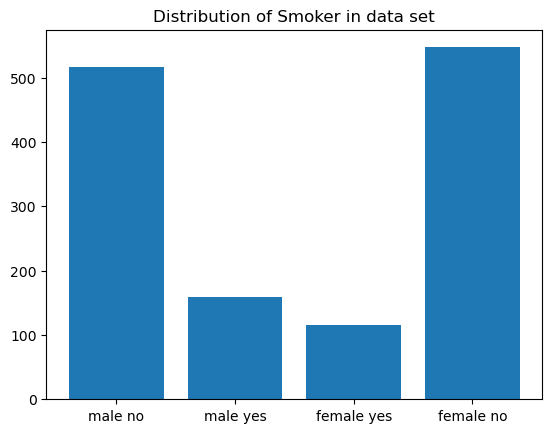

In [11]:
plt.bar(rows,cols)
plt.title("Distribution of Smoker in data set")

# Apply Label encoder to sex, smoker, region
- In this case:
    + Sex: male=0 female=1
    + smokerLabel: yes=1, no=0
- Region really should be one-hot encoded

In [12]:
from pyspark.ml.feature import StringIndexer

for col in ['sex','smoker','region']:
    Label_encoder=StringIndexer(inputCol=col,outputCol=col+"Label")
    df=Label_encoder.fit(df).transform(df)

df.show()

+----+------+------+--------+------+---------+---------+--------+-----------+-----------+
| age|   sex|   bmi|children|smoker|   region|  charges|sexLabel|smokerLabel|regionLabel|
+----+------+------+--------+------+---------+---------+--------+-----------+-----------+
|19.0|female|  27.9|     0.0|   yes|southwest|16884.924|     1.0|        1.0|        2.0|
|18.0|  male| 33.77|     1.0|    no|southeast|1725.5522|     0.0|        0.0|        0.0|
|28.0|  male|  33.0|     3.0|    no|southeast| 4449.462|     0.0|        0.0|        0.0|
|33.0|  male|22.705|     0.0|    no|northwest| 21984.47|     0.0|        0.0|        1.0|
|32.0|  male| 28.88|     0.0|    no|northwest|3866.8552|     0.0|        0.0|        1.0|
|31.0|female| 25.74|     0.0|    no|southeast|3756.6216|     1.0|        0.0|        0.0|
|46.0|female| 33.44|     1.0|    no|southeast|  8240.59|     1.0|        0.0|        0.0|
|37.0|female| 27.74|     3.0|    no|northwest|7281.5054|     1.0|        0.0|        1.0|
|37.0|  ma

In [13]:
df.select('regionLabel').distinct().collect()

[Row(regionLabel=0.0),
 Row(regionLabel=1.0),
 Row(regionLabel=3.0),
 Row(regionLabel=2.0)]

In [14]:
df.select('region').distinct().collect()

[Row(region='northwest'),
 Row(region='southeast'),
 Row(region='northeast'),
 Row(region='southwest')]

# Create feature columns to get ready for linear regression:

In [15]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Assembler = VectorAssembler(inputCols=['age','sexLabel','smokerLabel','regionLabel',
                                       'bmi','children'],
                           outputCol='features')
df=Assembler.transform(df)

In [16]:
df.show()

+----+------+------+--------+------+---------+---------+--------+-----------+-----------+--------------------+
| age|   sex|   bmi|children|smoker|   region|  charges|sexLabel|smokerLabel|regionLabel|            features|
+----+------+------+--------+------+---------+---------+--------+-----------+-----------+--------------------+
|19.0|female|  27.9|     0.0|   yes|southwest|16884.924|     1.0|        1.0|        2.0|[19.0,1.0,1.0,2.0...|
|18.0|  male| 33.77|     1.0|    no|southeast|1725.5522|     0.0|        0.0|        0.0|[18.0,0.0,0.0,0.0...|
|28.0|  male|  33.0|     3.0|    no|southeast| 4449.462|     0.0|        0.0|        0.0|[28.0,0.0,0.0,0.0...|
|33.0|  male|22.705|     0.0|    no|northwest| 21984.47|     0.0|        0.0|        1.0|[33.0,0.0,0.0,1.0...|
|32.0|  male| 28.88|     0.0|    no|northwest|3866.8552|     0.0|        0.0|        1.0|[32.0,0.0,0.0,1.0...|
|31.0|female| 25.74|     0.0|    no|southeast|3756.6216|     1.0|        0.0|        0.0|[31.0,1.0,0.0,0.0...|
|

In [17]:
df_train_test=df.select('features','charges')

In [18]:
df_train_test.show()

+--------------------+---------+
|            features|  charges|
+--------------------+---------+
|[19.0,1.0,1.0,2.0...|16884.924|
|[18.0,0.0,0.0,0.0...|1725.5522|
|[28.0,0.0,0.0,0.0...| 4449.462|
|[33.0,0.0,0.0,1.0...| 21984.47|
|[32.0,0.0,0.0,1.0...|3866.8552|
|[31.0,1.0,0.0,0.0...|3756.6216|
|[46.0,1.0,0.0,0.0...|  8240.59|
|[37.0,1.0,0.0,1.0...|7281.5054|
|[37.0,0.0,0.0,3.0...|6406.4106|
|[60.0,1.0,0.0,1.0...|28923.137|
|[25.0,0.0,0.0,3.0...|2721.3208|
|[62.0,1.0,1.0,0.0...|27808.725|
|[23.0,0.0,0.0,2.0...| 1826.843|
|[56.0,1.0,0.0,0.0...|11090.718|
|[27.0,0.0,1.0,0.0...|39611.758|
|[19.0,0.0,0.0,2.0...| 1837.237|
|[52.0,1.0,0.0,3.0...|10797.336|
|[23.0,0.0,0.0,3.0...|2395.1716|
|[56.0,0.0,0.0,2.0...|10602.385|
|[30.0,0.0,1.0,2.0...| 36837.47|
+--------------------+---------+
only showing top 20 rows



# Apply Linear Regression Model

In [19]:
trainDF,testDF=df_train_test.randomSplit([0.75,0.25],seed=1)

In [20]:
#Fit with linear regression model:
from pyspark.ml.regression import LinearRegression
model = LinearRegression(featuresCol="features", labelCol="charges")

model=model.fit(trainDF)

In [21]:
print("Intercept:", model.intercept)
print("coefficients:",model.coefficients)

Intercept: -12933.53721254052
coefficients: [263.3564543635745,138.2266898655472,23858.28030855387,228.46071778086855,326.65359525055726,462.00866249739636]


In [22]:
trainingSummary = model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 6042.776640
r2: 0.749401


# Test the data

In [23]:
pred=model.transform(testDF)
pred.select("prediction","charges","features").show(5)

+------------------+---------+--------------------+
|        prediction|  charges|            features|
+------------------+---------+--------------------+
| 2945.766065613994| 1137.011|(6,[0,4],[18.0,34...|
| 4202.950169599779|1532.4697|(6,[0,4],[21.0,35...|
|4634.1328156437485|1534.3044|(6,[0,4],[21.0,36...|
|1627.6873298264618|1664.9996|(6,[0,4],[22.0,26...|
|1783.2481226790442|1815.8759|(6,[0,4],[23.0,26...|
+------------------+---------+--------------------+
only showing top 5 rows



# Evaluate Regression model

In [24]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="charges",metricName="r2")
print("R2 on test: ",evaluator.evaluate(pred))

R2 on test:  0.7522498835090992


# Statistic Idea, unsupervised maybe LDA? KNN, Bisection Kmeans,

# Cross evaluation